<a href="https://colab.research.google.com/github/clopez95/Resume-Projects/blob/main/PythonProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#read the image
# function to load the dataset and return the dataset list
# containing elements of format [scans, target]
targets = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(scans):
    data = list()
    for target in targets: 
        path = os.path.join(scans, target)
        class_label = targets.index(target)
        for img in os.listdir(path):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(arr, (img_size, img_size))
                data.append([resized_arr, class_label])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#extracting the dataset
train = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/test')
val = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/val')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#split the data into training, testing and validation groups with variables to hold the target names.
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for image_scan, target in train:
    X_train.append(image_scan)
    y_train.append(target)

for image_scan, target in test:
    X_test.append(image_scan)
    y_test.append(target)
    
for image_scan, target in val:
    X_val.append(image_scan)
    y_val.append(target)

In [ ]:
# Normalize data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [ ]:
# resize data
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
#prevents overfitting and handles the imbalance in dataset

data_aug = ImageDataGenerator(
        rotation_range = 30,  #rotate 
        zoom_range = 0.2, #  zoom  
        width_shift_range=0.1,  #  shift images horizontally 
        height_shift_range=0.1,  #  shift images vertically
        horizontal_flip = True,  # flip images
        vertical_flip=False)  # no vertical flip

data_aug.fit(X_train)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_32 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 37, 37, 64)       

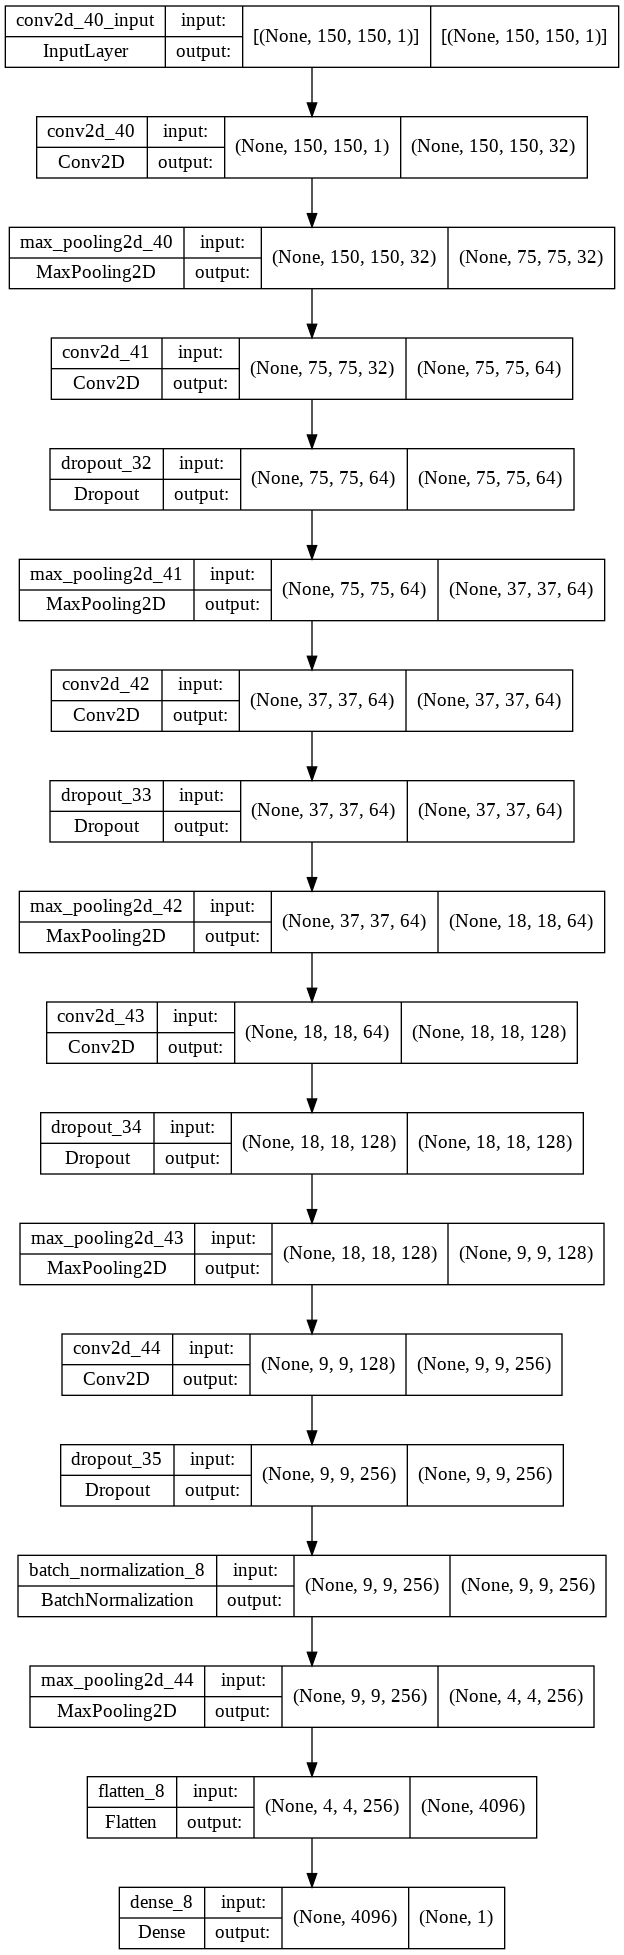

In [ ]:
#building the model
model = Sequential()
model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Conv2D(128 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(256 , (3,3)  , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Flatten())

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['acc'])
model.summary()
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
#learning rate reduction
LRR = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.2, min_lr=0.0001)

In [ ]:
history = model.fit(data_aug.flow(X_train, y_train, batch_size = 44) , epochs = 16 , validation_data = data_aug.flow(X_test, y_test) , callbacks = [LRR])

Epoch 1/16
119/119 [==============================] - 13s 101ms/step - loss: 0.6016 - acc: 0.7611 - val_loss: 0.6006 - val_acc: 0.8077 - lr: 0.0010
Epoch 2/16
119/119 [==============================] - 11s 96ms/step - loss: 0.3339 - acc: 0.8635 - val_loss: 0.6429 - val_acc: 0.6250 - lr: 0.0010
Epoch 3/16
119/119 [==============================] - ETA: 0s - loss: 0.2687 - acc: 0.8890
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
119/119 [==============================] - 12s 100ms/step - loss: 0.2687 - acc: 0.8890 - val_loss: 0.4968 - val_acc: 0.7228 - lr: 0.0010
Epoch 4/16
119/119 [==============================] - 12s 97ms/step - loss: 0.1837 - acc: 0.9323 - val_loss: 0.5436 - val_acc: 0.6795 - lr: 2.0000e-04
Epoch 5/16
119/119 [==============================] - ETA: 0s - loss: 0.1600 - acc: 0.9390
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001.
119/119 [==============================] - 12s 98ms/step - loss: 0.1600 - acc: 0.9390 - val_loss:

In [ ]:
model.save('PNmodel.h5')

In [ ]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 0s 12ms/step - loss: 0.2783 - acc: 0.9087


[0.2782999277114868, 0.9086538553237915]

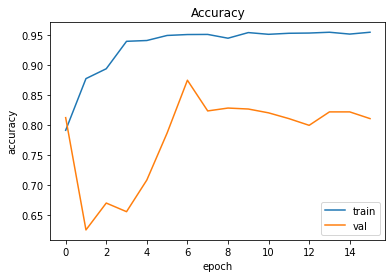

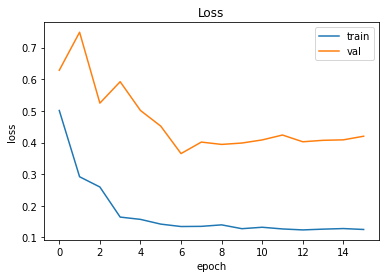

In [ ]:
#plotting the data to demonstrate the accuracy of the train and validations. 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

#plotting the data to demonstrate the loss of the train and validations. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()